# Getting to know the newspaper corpus

We'll mainly use `pandas` as a data manipulation tool:

In [1]:
import pandas as pd

Import sample of newspapers from CSV file:

In [2]:
df_path = "data/subsample500mixedocr-selected_mitch.csv"
df = pd.read_csv(df_path)
df.sample(3)

,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text
51,2620,910,art0004,"Denton and Haughton Examiner, etc.",British Library Living with Machines Project,1887-09-10,1887,9,10,"Denton, Greater Manchester, England",854,0.9756,liberal,1d,NEWS NOTES. Tin politic' principles which gui...
168,3060,202,art0108,"Bridport, Beaminster, and Lyme Regis Telegram ...",British Library Living with Machines Project,1877-02-02,1877,2,2,"Bridport, Dorset, England",192,0.9699,neutral,1d,EXTRAORDINARY _ RESULT OF WELL SINKING. Hugmo...
102,3039,814,art0033,The Northern Guardian.,British Library Living with Machines Project,1899-08-14,1899,8,14,"Hartlepool, Cleveland, England",75,0.9699,unionist,½ d,"PUBLIC NOTICES. SBOF 4.1,1 L L 3 L 00,.. 0 0 ..."


## General overviews

Doing a very high-level exploration of the corpus using the metadata is always the first step before getting to the text itself. What we'll do now is based on a random, small sample, but, of course, one could do the same at scale. 

Let's first have a look at which and how many titles are present in the sample. 

Keep in mind that we are using the _non-normalized_ form in which the title appears in the digitized collections. What this means is:
1) There will be all sorts of end-of-string punctuation which you normally don't find in a normalized newspaper title, e.g. full stops, colons (preceded by a space, e.g. "The Potteries Examiner : "), etc.
2) Even the slightest variation in the way a title is presented in the metadata (e.g. an extra space or full stop at the end at the end, a capitalized word, etc.) will cause the string variations to be counted as two titles, even though they should be considered one. 
3) Some newspapers have changed title more or less drastically (i.e. not just a punctuation mark) throughout the years. 

E.g. the following are all variation of the title "Penistone, Stocksbridge and Hoyland Express":
- "Penistone, Stocksbridge and Hoyland Express, etc."
- "Penistone, Stocksbridge, Hoyland and Ecclesfield & Chapeltown Express."
- "Penistone, Stocksbridge, Hoyland & Chapeltown Express, etc."

Or, more drastically, the following are all variations of "The Northern Weekly Gazette":
- "Northern Weekly Gazette.",
- "The North-Eastern Weekly Gazette.",
- "The Middlesbrough Gazette and General Advertiser.",
- "Middlesbrough & Stockton Gazette and General Advertiser.",
- "Stockton Gazette and Middlesbrough Times.",
- "Middlesbro' & Stockton Gazette and General Advertiser.",
- "The Weekly Gazette for Middlesbrough, Stockton, Hartlepool and Cleveland District."

Let's have look at how many titles are represented in our sample:

In [3]:
# Get unique newspaper titles
unique_titles = df['newspaper_title'].unique()
print(f"Unique Newspaper Titles: {len(unique_titles)}\n")
print('\n'.join(sorted(unique_titles)))

Unique Newspaper Titles: 73

Alston Herald, and East Cumberland Advertiser.
Bargoed Journal.
Barnsley Telephone.
Beverley and East Riding Telegraph.
Blandford, Wimborne and Poole Telegram.
Bridgend & Neath Chronicle, and County of Glamorgan Advertiser.
Bridgend Chronicle, Cowbridge, Llantrisant, and Maesteg Advertiser.
Bridlington and Quay Gazette.
Bridport, Beaminster, and Lyme Regis Telegram and Dorset, Somerset, and Devon Advertiser.
Brighouse & Rastrick Gazette.
Brighouse Gazette and Local Railway Guide.
Darlington & Richmond Herald.
Denton & Haughton Weekly News, and Audenshaw, Hooley Hill, and Dukinfield Advertiser.
Denton Examiner, Audenshaw, Hooley Hill and Dukinfield Advertiser.
Denton and Haughton Examiner, etc.
Glasgow Courier.
Irvine Express and North Ayrshire Post.
Irvine Express.
Lancaster Standard and County Advertiser.
Liverpool Weekly Courier.
Middlesbro' & Stockton Gazette and General Advertiser.
Middlesbrough & Stockton Gazette and General Advertiser.
Nantwich, Sandb

A second thing one wants to check is the size of the dataset. Generally, one way of giving an idea of this is in terms of number of words. 

A crude way to check the total number of "words" is by splitting all the text at any whitespace character (spaces (`\s`), newlines (`\n`), and tabs (`\t`)) and counting how many units we got as a result.

Note: because of huge differences in OCR quality from text to text, this method will often not be precise.

In [4]:
# Calculate total word count from text column
# split() means 'split at any whitepoint character'. 
# You could specify a whitespace instead, e.g. '\s', which would exclude tabs and newlines.
total_word_count = df['text'].apply(lambda x: len(str(x).split())).sum() 
print(f"Total Word Count: {total_word_count}")

Total Word Count: 257684


We can add a column detailing how many words each 'item' (i.e. roughly 'article') has:

In [5]:
df['word_count'] = [len(x.split(' ')) for x in df['text'].astype(str)]

This way we can check how many words each title has represented in our dataset, or check the title with the highest number of words:

In [6]:
df.groupby(['newspaper_title']).agg(total_words=('word_count', 'sum')).reset_index().sort_values(by='total_words',ascending=False)

,newspaper_title,total_words
33,The Birkenhead News and Wirral General Adverti...,31818
38,The Cotton Factory Times.,19868
72,Widnes Examiner.,14131
41,The Dorset County Express and Agricultural Gaz...,11888
8,"Bridport, Beaminster, and Lyme Regis Telegram ...",11274
...,...,...
55,The Pontypridd District Herald and Rhondda Val...,110
40,"The Dewsbury Chronicle, and West Riding Advert...",82
44,The Halifax Comet.,30
10,Brighouse Gazette and Local Railway Guide.,27


Among the various metadata associated with each item, we have the date of publication. We can use this to check the temporal coverage of the dataset and visualize it:

Year span: 1845 to 1920


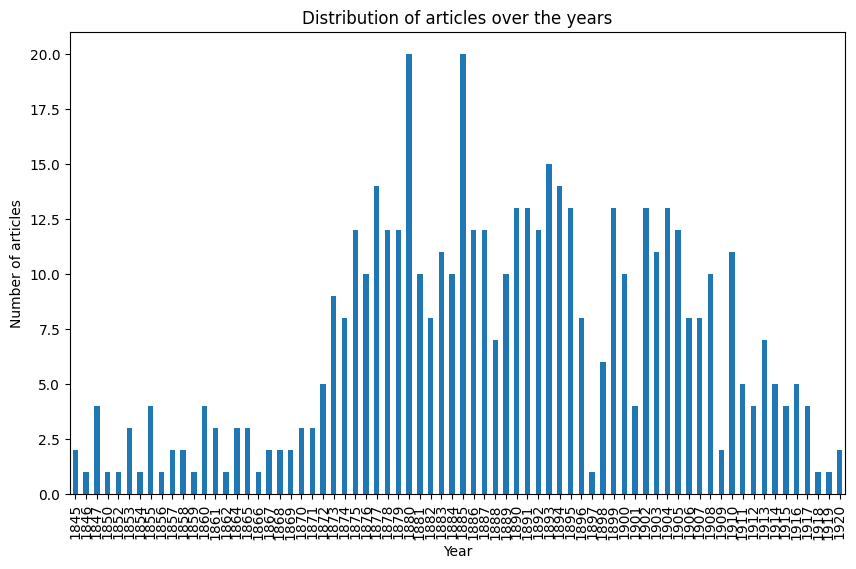

In [7]:
import matplotlib.pyplot as plt

# determine the year span of the corpus
min_year = df['year'].min()
max_year = df['year'].max()
print(f"Year span: {min_year} to {max_year}")

# plot distribution of articles over the years
plt.figure(figsize=(10, 6))
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of articles over the years')
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.show()


We can not only check the first and last date covered by the data, but also get an intuitive first idea of the (im)balance in how many articles we have per period. Naturally, counting the number of items per year is a _very_ rough approximation of the amount of content per year. This is because:
1) segmentation of newspaper pages into items is far from perfect (as we'll see)
2) even when segmentation _did_ lead to individual articles, articles can vary greatly in length.

Let's dig into this some more.

## A closer look at item lengths

Segmentation into 'items'/'articles' was done automatically, so the we'll often find more than one article counted as one (i.e. one row in our dataframe), or, less frequently, only a portion of one article (i.e. article was cut short). Article length (i.e. number of words) can give us an idea of what's the distribution of wrongly segmented articles. 

Let's print some high-level stats about this:

In [8]:
df['word_count'].describe()

count     500.000000
mean      522.226000
std       864.991605
min         1.000000
25%        68.000000
50%       213.500000
75%       510.000000
max      6055.000000
Name: word_count, dtype: float64

And visualize it:

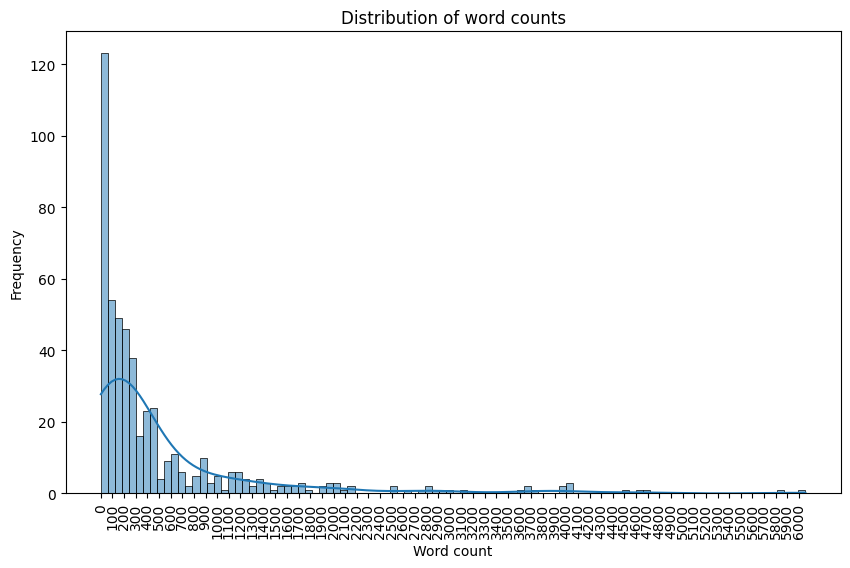

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set max_count for consistent x-ticks
max_count = df['word_count'].max()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=100, kde=True)
plt.title('Distribution of word counts')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.xticks(range(0, max_count, 100), rotation=90)
plt.show()


As was already clear from the second quartile (50%), or median, from the previous stats, at least half of the items have around 200 words or less. Obviously, an 'item' with 1 word will not repesent an article. Likewise, though, a 6000-word item will also very unlikely represent an article.

## Page missegmentation and identifying articles headlines

One of the main issues in working with digitized historical newspaper is page segmentation. More often than not you'll need to work at the 'article' level, but singling out articles can be challenging. Let's look at longer items, to see what they actually contain. 

First, create a subset with only items with > 500 words (totally arbitrary number, but more likely to capture items containing several articles).

In [10]:
long_articles_df = df[df['word_count'] > 500].reset_index(drop='index')

Have a look at some random 'articles' from our sample (change the number in square brackets):

In [11]:
pd.set_option('display.max_colwidth', 50)

The following specific item, for instance, has at least 3 articles in it:

In [12]:
long_articles_df['text'][15]

'ALLEGED FORGERY .ON THE BANK  OF ENGLAND.  Arthur Reynolds Schirges a clerk, has been Cammitted for trial from the London Mansion House on a charge of forging a cheque for £2OO with intent to defraud the Bank of England. Prisoner presented at the Bank of England a cheque for £2OO, purporting to he signed by Messrs. H. Clarkson and Co., shipbrokers, Billiter-street, who keep an account there. It was discovered on inquiry that the che.que had been issued, not to Messrs. Clarkson, but to °the/ customers of the bank, Messrs. Chorley and Crawford.  THE CABINET AND THE LIBERAL UNIONISTS. Since the last Cabinet Council there has been, the Press Association says, much activity among the members of the Literal Unionists\' Associa ion in London, and the views of the leaders, and especially of Lord Hartingtom have been ascertsim d by the Priem Minister and other members of the Cabinet. Inter-views have taken place between Lord Salisbury and Lord Ilartington and between Sir Michael Hicks-Beach an

In fact, looking at the newspaper page, we can see that it corresponds to three separate articles:

<img src="figures/page.png" alt="optional description" width="700"/>

Some long items are genuinely long articles, but several are multiple articles together. We can try and marginally improve segmentation and see what problems may arise. We'll try the _very_ crude approach of splitting text where there are longer (>=3 words, though this is completely arbitrary) substrings in all-caps (signalling, most often, a new headline). We'll use `re`gular expressions to do this.

There are several tools that can help you formulate the right regex for capturing what you need. [regex101.com](https://regex101.com/) is one of them, but you can now ask ChatGPT for help too.

Import the `re` package which allows you to search for a string matching a specific pattern via regular expressions.

In [13]:
import re

If we look closely at some articles, we immediately see that more often than not articles are introduced by a headline in all-caps, ending in a full stop. We can try leveraging all-caps + full stip strings to identify potential headlines and, later, use the identified headlines to split items into its articles, if needed. 

More specifically, however, we want to capture sequences of uppercase letters that are possibly mixed with non-word characters (i.e. some punctuation marks and whitespace) and numeric characters.

Let's breakdown the regex used below:

- `\b`: A word boundary anchor, to match strings at the beginning of a word (i.e. following a non-word character). This avoids to capture all-caps randomly appearing after lowercase letters (e.g. as a result of OCR errors).
- `[A-Z]{3,}`: This matches a sequence of at least three uppercase letters (A-Z). {3,} specifies that the preceding character class [A-Z] must appear at least three times but can appear more times.
- `(?:[\W]*[A-Z0-9])*`: non-capturing group (indicated by ?: at the start). It matches the following pattern zero or more times (as indicated by the * quantifier). Non-capturing groups are simply ways of grouping parts of a regex without meaning to only capture it separately. While `[A-Z]{3,}` ensured the string contains at least a word in uppercase (with at least 3 characters), this groups adds that it can also contain punctuation, spaces, or numbers. We did not add numbers, spaces, and punctuation directly to the previous part of the regex because otherwise it would capture _any_ long number or random punctuation/space sequences (not just those part of an all-caps string). See following two points for what's inside this group.
- `[\W]*`: Matches zero or more non-word characters. Non-word characters (\W) include anything that is not a letter, digit, or underscore (_).
- `[A-Z0-9]`: Matches a single character that is an uppercase letter (A-Z) or a digit (0-9).
- `\b`: Another word boundary anchor, ensuring that the pattern ends at a word boundary.
- `\.`: Matches a literal dot (.) character. This character must appear immediately after the word boundary.

NB: This particular regex was formulated after a bit of trial and error. This is why, for example, the '3 characters' rule may seem very specific, and so does the rest of the regex, but it's what appeared to work best based on running previous versions of a regex, and running and adjusting it several times until we were relatively satisfied with the segmentation.
In a real-world scenario, we would complicate the regex a bit further, by adding, e.g. an additional option to allow single or two-character strings at the beginning of the matches. So keep in mind that the current regex will not capture "I" or "AN" or "A" at the beginning of headlines.

In [14]:
def extract_full_caps_sequences(text):
    # Regular expression to find sequences of full caps words (more than one word in a row)
    full_caps_sequences = re.findall(r'\b[A-Z]{3,}(?:[\W]*[A-Z0-9])*\b\.', text)
    return full_caps_sequences

Let's apply the function to the text column and save the output as a separate object:

In [15]:
df['text'] = df['text'].astype(str)
rough_headlines = df['text'].apply(extract_full_caps_sequences)
rough_headlines

0                                  [THE TICHBORNE CASE.]
1      [THE CLERGY AND TRADE UNIONS.  LETTER FROM REV...
2                  [INDUSTRIAL REVIEW  OUR LEGISLATORS.]
3              [WOOLISTON., UNDISTAICLIC IN DIYVICULTY.]
4      [THE FINE ART CO-OPERATIVE SUPPLY  ASSOCIATION...
                             ...                        
495                                                   []
496                                                   []
497                                                   []
498                         [CABER., SILVER GOLD CASES.]
499                                                   []
Name: text, Length: 500, dtype: object

You can immediately see that this cannot but be an extremely crude approach to finding headlines, as the empty lists show. However, over a very large collection, they may still be somewhat useful for data exploration.

Let's check how many 'articles' might contain more than one article. We do this by 'exploding', i.e. expanding, several matched items in a single row into separate rows.

In [16]:
# Explode the articles into separate rows
rough_headlines = rough_headlines.explode('text').reset_index(drop=True).dropna()
rough_headlines = rough_headlines.str.replace(r'[^0-9A-Z ]+', '', regex=True).str.strip()
rough_headlines

0                                      THE TICHBORNE CASE
1       THE CLERGY AND TRADE UNIONS  LETTER FROM REV J...
2                                          PRICE TWOPENCE
3                          THE LABOUR AND 0111 ER MAPRETS
4                      INDUSTRIAL REVIEW  OUR LEGISLATORS
                              ...                        
1730                                       OFICI S WWI MM
1731                                        LIEII ANDIEWS
1732                                            POIBTLAXD
1737                                                CABER
1738                                    SILVER GOLD CASES
Name: text, Length: 1616, dtype: object

Several of these are very likely ads, which use all-caps as a highlighting technique. For example:

In [17]:
(df[df['text'].str.contains('SILVER GOLD CASES', na=False)]['text'].reset_index(drop='index')[0])

'„ E S 3 8 Lunn ATCH  Is Better Value than any non-KeylessEnglish Lever ever made.  CABER.  tEE-Q.R\'l" E Li LEVER WATCH of BEST LONDON MAKE, with Chronometer Balance. fully Jewelled and of special strength throughout. Made in Four Sizes—Gentlemen and Youths (as illus— trated)? Working Men generally, specially large for Miners and Railway Men, and extra small tor Lathes. In Sterling Silver Crystal Glass Cages, 0 ss. In 18-carat Gold Crystal Glass Cases, iientleinans size, Zl2 12s, Lady\'s size, £lO 10s. Guaranteed for strength, accuracy, durability, and value.  SILVER GOLD CASES. \' , •••,\' q• ~ , , 5 _ , ,• .... ~ A• • ,--4. e .- III? I? , ,„?.... . ____, • C‹,,,,,,9 ./%•":,\',\' • .... --4*--. . "01 • •,. • k, 4 •,..-4 / IS• ,‘.. AI ‘ , b , . : •c, 4 \' /Ai c, \\ \\k„ 4"• e, \'\'\'%,„,;2\'s-: -- 1-- ---\' ,40(\'\'\' VIRE" UK \'ER PLA\' -INTGLIsii '

We can also create a separate column with the identified potential headlines:

In [18]:
df['headlines'] = df['text'].apply(extract_full_caps_sequences)

You can also reorganize the dataframe by placing one potential headline per row and copying the relevant metadata:

In [19]:
rough_headlines_df = df.explode('headlines')
rough_headlines_df['headlines'] = rough_headlines_df['headlines'].str.replace(r'[^0-9A-Z ]+', '', regex=True).str.strip()
rough_headlines_df.head(5)

,publication_code,issue_id,item_id,newspaper_title,data_provider,date,year,month,day,location,word_count,ocrquality,political_leaning_label,price_label,text,headlines
0,2249,624,art0017,The Bee-Hive.,British Library Heritage Made Digital Newspapers,1871-06-24,1871,6,24,"London, England",263,0.9098,liberal,1d,"THE TICHBORNE CASE. On Tuesday, before the So...",THE TICHBORNE CASE
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2772,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....,THE CLERGY AND TRADE UNIONS LETTER FROM REV J...
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2772,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....,PRICE TWOPENCE
1,2250,908,art0002,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1877-09-08,1877,9,8,"London, England",2772,0.9841,liberal,2d,THE CLERGY AND TRADE UNIONS. LETTER FROM REV....,THE LABOUR AND 0111 ER MAPRETS
2,2250,406,art0024,"The Industrial Review, Social and Political.",British Library Heritage Made Digital Newspapers,1878-04-06,1878,4,6,"London, England",305,0.9870,liberal,2d,INDUSTRIAL REVIEW OUR LEGISLATORS. THE unrul...,INDUSTRIAL REVIEW OUR LEGISLATORS


And perhaps save the output for separate inspection later:

In [20]:
rough_headlines_df.to_csv('outputs/headlines_df.csv',index=False)

There is probably not much gain in trying to improve segmentation with a rule-based approach (e.g. look for all caps) across the collection, as it would be time-consuming. However, it may be necessary when constructing a smaller sample to be annotated (for whatever task, e.g. classification).

Let's pretend our sample contains only items containing at least one occurrence from a specified list of keywords and that we now want to 'clean' the items as much as possible by attempting to only keep the article. One way to go about it is to apply the regex above to the `text` column, then segmenting the item into as many subitems as there are matches (i.e. potential headlines). Then we can take all the text from one headline to the last character before the beginning of the next headline as one article (obviously, this will have no effect on items for which there was no match, i.e. which probably contain only one article already). 

Let's write a function that identifies potential headlines and then considers the text running from one potential headline to the next as one article.

In [21]:
def segment_articles(text):
    # Define a regular expression to identify headlines accurately
    headline_pattern = re.compile(r'\b[A-Z]{3,}(?:[\W]*[A-Z0-9])*\b\.')

    # Find all matches using finditer which gives us match objects with start and end info
    matches = list(re.finditer(headline_pattern, text))
    articles = []

    # Iterate over matches to slice the text correctly
    for i in range(len(matches)):
        start = matches[i].start()  # Start of current headline
        # End is either start of the next headline or end of text if no more headlines
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
        article = text[start:end].strip()
        articles.append(article)

    return articles

Let's apply the function to the `text` column, saving the output as a separate, new `articles` column:

In [22]:
df['articles'] = df.apply(lambda x: segment_articles(x['text']), axis=1)

And `explode` the dataframe based on this new column:

In [23]:
df_articles = df.explode('articles')

At this point, you get one potential 'article' per row, rather than simply 'items'. At this point, depending on your reseahc needs, you further manipulate the dataframe. Some variables, for example, will refer to the original 'item', such as the word count. This can be redone, to reflect the new 'article' text. Or, if you are working with a keyword-based sample, you may need to filter out articles that do not contain the keywords of interest anymore after the new segmentation.

You can the save the sample to be used later, after dropping any rows containing empty cells:

In [24]:
df_articles.dropna().to_csv('outputs/articles.csv',index=False)

## Add bespoke variables based on other variables

When preparing a research sample, you'll often need to add bespoke variables based on other variables. For instance, you may not need fine-grained information about places of publication, but you may be more interested in, say, higher-level geographical or geo-political regions. Similarly, you may want to normalize the title variants (as noted above) by mapping them to one 'normalized' title. Thi is the example we'll be looking at.

This type of data enrichment (which may simply be considered as 'cleaning' by some), can be done via Python `dict`ionaries, which map values currently found in your data to the bespoke value you want to assign. The first value is called a dictionary _key_, the second value is simply the _value_. Keys need to be unique throughout the dictionary, values can be repeated. You can have as many key-value pairs as needed. The format is the following:

```
arbitrary_dict_name = {
    key1 : value1,
    key2 : value2,
    key3 : value1
}
```

You can then change the values in a dataframe column corresponding to any of the keys in your dictionary to the respective value. In pandas you simply add `.map(arbitrary_dict_name)` to the column, e.g. `df['newspaper_title_normalized'] = df['newspaper_title'].map(arbitrary_dict_name)`.

### Normalizing titles

We have already created a dictionary mapping title variants across time to their normalized or unifying form. This was done manually by consulting the [British Newspaper Archive](https://www.britishnewspaperarchive.co.uk/titles/) 'Titles' page. The entry for a title would look like this:

<img src="figures/northern_weekly_gazette.png" alt="optional description" width="400"/>

Where we can see the newspaper normalized under the unifying title 'Northern Weekly Gazette' changed its name multiple times throughout the years. Each of the title variants will be a key in our dictionary and for all of them the value will be 'Northern Weekly Gazette'.

This was the resulting mapping (NB: this contains way more titles that in the subsample we are using):

In [25]:
normalizedtitles = {"The Sun.": "The Sun",
 "The Express.": "The Express",
 "The Birkenhead News and Wirral General Advertiser.": "Birkenhead News",
 "The Liverpool Standard and General Commercial Advertiser.": "The Liverpool Standard",
 "The Liverpool Standard, and General Advertiser.": "The Liverpool Standard",
 "Widnes Examiner.": "Widnes Examiner",
 "The Cotton Factory Times.": "The Cotton Factory Times",
 "Glasgow Courier.": "Glasgow Courier",
 "The British Press; or, Morning Literary Advertiser.": "The British Press",
 "Swansea and Glamorgan Herald, and South Wales Free Press.": "The Swansea and Glamorgan Herald",
 "Northern Weekly Gazette.": "Northern Weekly Gazette",
 "The North-Eastern Weekly Gazette.": "Northern Weekly Gazette",
 "The Middlesbrough Gazette and General Advertiser.": "Northern Weekly Gazette",
 "Middlesbro & Stockton Gazette and General Advertiser.": "Northern Weekly Gazette",
 "Middlesbrough & Stockton Gazette and General Advertiser.": "Northern Weekly Gazette",
 "Stockton Gazette and Middlesbrough Times.": "Northern Weekly Gazette",
 "The Weekly Gazette for Middlesbrough, Stockton, Hartlepool and Cleveland District": "Northern Weekly Gazette",
 "The Dorset County Express and Agricultural Gazette.": "The Dorset County Express and Agricultural Gazette",
 "Stockton Herald, South Durham and Cleveland Advertiser.": "Stockton Herald, South Durham and Cleveland Advertiser",
 "The Haslingden Gazette.": "The Haslingden Gazette",
 "The Central Glamorgan Gazette, and General, Commercial, and Agricultural Advertiser.": "The Central Glamorgan Gazette",
 "The Northern Guardian.": "The Northern Guardian",
 "The Blackpool Herald.": "Blackpool Gazette & Herald",
 "Blackpool Herald and Fylde Advertiser.": "Blackpool Gazette & Herald",
 "The Stourbridge Observer, Cradley Heath, Halesowen & District Chronicle.": "Cradley Heath & Stourbridge Observer",
 "Cradley Heath & Stourbridge Observer.": "Cradley Heath & Stourbridge Observer",
 "The Observer, Cradley Heath, Halesowen & District Chronicle": "Cradley Heath & Stourbridge Observer",
 "Penistone, Stocksbridge and Hoyland Express, etc.": "Penistone, Stocksbridge and Hoyland Express",
 "Penistone, Stocksbridge, Hoyland and Ecclesfield & Chapeltown Express.": "Penistone, Stocksbridge and Hoyland Express",
 "Penistone, Stocksbridge, Hoyland & Chapeltown Express, etc.": "Penistone, Stocksbridge and Hoyland Express",
 "The Telegram.": "Weymouth Telegram",
 "The Weymouth, Portland and Dorchester Telegram": "Weymouth Telegram",
 "Denton and Haughton Examiner, etc.": "Denton and Haughton Examiner",
 "Denton Examiner, Audenshaw, Hooley Hill and Dukinfield Advertiser.": "Denton and Haughton Examiner",
 "Denton & Haughton Weekly News, and Audenshaw, Hooley Hill, and Dukinfield Advertiser.": "Denton and Haughton Examiner",
 "The Denton, Haughton, & District Weekly News.": "Denton and Haughton Examiner",
 "The Warwickshire Herald.": "Warwickshire Herald",
 "Nelson Chronicle, Colne Observer, and Clitheroe Division News.": "Nelson Chronicle, Colne Observer, and Clitheroe Division News",
 "The Daily Times.": "The Northern Daily Times",
 "Northern Times": "The Northern Daily Times",
 "The Northern Daily Times.": "The Northern Daily Times",
 "The Barrow Herald and Furness Advertiser.": "Barrow Herald and Furness Advertiser",
 "Blandford, Wimborne and Poole Telegram.": "The Blandford and Wimborne Telegram",
 "The Blandford and Wimbourne Telegram.": "The Blandford and Wimborne Telegram",
 "Bridlington and Quay Gazette.": "Bridlington and Quay Gazette",
 "Brighouse & Rastrick Gazette.": "Brighouse & Rastrick Gazette",
 "Brighouse Gazette and Local Railway Guide.": "Brighouse & Rastrick Gazette",
 "The Herald of Wales and Monmouthshire Recorder.": "The Herald of Wales",
 "The Herald of Wales.": "The Herald of Wales",
 "Bridport, Beaminster, and Lyme Regis Telegram and Dorset, Somerset, and Devon Advertiser.": "Bridport, Beaminster, and Lyme Regis Telegram",
 "The Atherstone, Nuneaton, and Warwickshire Times.": "The Atherstone, Nuneaton, and Warwickshire Times",
 "The Potteries Examiner :": "The Potteries Examiner",
 "The Staffordshire and Potteries Examiner.": "The Potteries Examiner",
 "Star.": "The Star",
 "The Kenilworth Advertiser.": "The Kenilworth Advertiser",
 "Lancaster Standard and County Advertiser.": "Lancaster Standard and County Advertiser",
 "The Dewsbury Chronicle, and West Riding Advertiser.": "Dewsbury Chronicle and West Riding Advertiser",
 "The Warrington & Mid-Cheshire Examiner.": "The Warrington Examiner",
 "The Warrington Examiner.": "The Warrington Examiner",
 "The Poole Telegram.": "The Poole Telegram",
 "Runcorn Examiner.": "Runcorn Examiner",
 "Runcorn and Widnes Examiner.": "Runcorn Examiner",
 "The Press.": "The Press",
 "Bridgend & Neath Chronicle, and County of Glamorgan Advertiser.": "Bridgend Chronicle, Cowbridge, Llantrisant, and Maesteg Advertiser",
 "Bridgend Chronicle, Cowbridge, Llantrisant, and Maesteg Advertiser.": "Bridgend Chronicle, Cowbridge, Llantrisant, and Maesteg Advertiser",
 "The Bee-Hive :": "The Bee-Hive",
 "The Bee-Hive.": "The Bee-Hive",
 "The Penny Bee-Hive.": "The Bee-Hive",
 "The Pontypridd District Herald and Rhondda Valley, Llantrisant, Caerphilly, and Mountain Ash News.": "The Pontypridd District Herald",
 "Irvine Express and North Ayrshire Post.": "Irvine Express",
 "Irvine Express.": "Irvine Express",
 "Weekly News.": "Weekly News",
 "The Glasgow Chronicle.": "The Glasgow Chronicle",
 "The Slaithwaite Guardian and Colne Valley News.": "Colne Valley Guardian",
 "The North Cumberland Reformer.": "The North Cumberland Reformer",
 "The Shropshire Examiner and all round the Wrekin advertiser.": "The Shropshire Examiner",
 "The Cannock Chase Examiner.": "The Cannock Chase Examiner",
 "The Weekly Journal.": "The Weekly Journal",
 "The Manchester Examiner.": "The Manchester Examiner",
 "Bargoed Journal.": "Bargoed Journal",
 "New Tredegar, Bargoed & Caerphilly Journal.": "Bargoed Journal",
 "The Halifax Comet.": "The Halifax Comet",
 "The Forest of Dean Examiner :": "The Forest of Dean Examiner",
 "The Tamworth Examiner and Working Mens Journal.": "The Tamworth Miners' Examiner and Working Men's Journal",
 "The Tamworth Miners Examiner and Working Mens Journal.": "The Tamworth Miners' Examiner and Working Men's Journal",
 "Alston Herald, and East Cumberland Advertiser.": "Alston Herald and East Cumberland Advertiser",
 "Darlington & Richmond Herald.": "Darlington & Richmond Herald",
 "The Darlington & Stockton Telegraph, Richmond Herald, South Durham and North York Review.": "Darlington & Richmond Herald",
 "Beverley and East Riding Telegraph.": "The East Riding Telegraph",
 "The East Riding Telegraph.": "The East Riding Telegraph",
 "Blandford Weekly News.": "Blandford Weekly News",
 "The Miner and Workmans Advocate.": "British Miner and General Newsman",
 "The Commonwealth.": "British Miner and General Newsman",
 "The Workmans Advocate": "British Miner and General Newsman",
 "The Miner": "British Miner and General Newsman",
 "British Miner and General Newsman": "British Miner and General Newsman",
 "The Northern News.": "The Northern News",
 "Nantwich, Sandbach & Crewe Star": "Nantwich, Sandbach & Crewe Star",
 "The Lancaster Herald, and Town and County Advertiser.": "Lancaster Herald and Town and County Advertiser",
 "The Wolverhampton and Midland Counties Advertiser.": "The Midland examiner and Wolverhampton times",
 "The Midland Examiner and Wolverhampton Times.": "The Midland examiner and Wolverhampton times",
 "The Midland Examiner and Times.": "The Midland examiner and Wolverhampton times",
 "The Wolverhampton Times and Bilston, Willenhall, Wednesfield, and Sedgley Journal.": "The Midland examiner and Wolverhampton times",
 "Liverpool Weekly Courier.": "Liverpool Weekly Courier",
 "The St. Helens Examiner, and Prescot Weekly News.": "St. Helens Examiner",
 "The Stockton Examiner, and South Durham and North Yorkshire Herald.": "Stockton Examiner and South Durham and North Yorkshire Herald",
 "The Stockton & Thornaby Herald and South Durham Advertiser": "Stockton Examiner and South Durham and North Yorkshire Herald",
 "The Industrial Review, Social and Political.": "The Industrial Review, Social and Political",
 "Swansea Journal and South Wales Liberal.": "Swansea Journal and South Wales Liberal",
 "The Atherstone Times.": "The Atherstone Times.",
 "The South Staffordshire Examiner.": "The South Staffordshire Examiner",
 "The National Register.": "The National Register",
 "The Nuneaton Times.": "The Nuneaton Times",
 "The Statesman.": "The Statesman",
 "Stretford and Urmston Examiner.": "Stretford and Urmston Examiner",
 "Stalybridge Examiner, and Ashton, Dukinfield and Mossley Advertiser.": "Stalybridge Examiner",
 "Halifax Local Opinion.": "Halifax Local Opinion",
 "The Ripon Observer.": "The Ripon Observer",
 "Barnsley Telephone.": "Barnsley Telephone",
 "Colored News.": "Colored News",
"Middlesbro' & Stockton Gazette and General Advertiser.": "Northern Weekly Gazette",
"The Weekly Gazette for Middlesbrough, Stockton, Hartlepool and Cleveland District.": "Northern Weekly Gazette",
"The Miner and Workman's Advocate.": "British Miner and General Newsman",
"The Tamworth Examiner and Working Men's Journal.": "Tamworth Miners' Examiner and Working Men's Journal",
"The Tamworth Miners' Examiner and Working Men's Journal.": "Tamworth Miners' Examiner and Working Men's Journal",
"The Weymouth, Portland and Dorchester Telegram.": "Weymouth Telegram",
"The Workman's Advocate.": "The Workman's Advocate"}

Let's remind ourselves of how many unique titles we have pre-normalization:

In [26]:
len(unique_titles)

73

And let's now normalize the title and add a column with the normalized titles (while keeping the unnormalized one too):

In [27]:
df['title_clean'] = df['newspaper_title'].map(normalizedtitles)

After normalizing the titles, we see that several titles were conflated:

In [28]:
len(df['title_clean'].value_counts())

57

Now that you have clean versions of the titles, you may want to create a revised overview of your dataset, including info like number of words per title, temporal coverage, etc., similarly to what was done in [this blog post](https://livingwithmachines.ac.uk/public-domain-newspaper-titles-in-living-with-machines/) by our team. Let's quickly create an overview table with word counts and temporal coverage per title.

Count number of words per title by leveraging the 'word_count' column:

In [29]:
overview_table = df.groupby('title_clean')['word_count'].sum()
overview_table = pd.DataFrame(overview_table).reset_index().sort_values(by='word_count',ascending=False)
overview_table

,title_clean,word_count
4,Birkenhead News,31818
32,The Cotton Factory Times,19868
56,Widnes Examiner,14131
13,Denton and Haughton Examiner,13169
33,The Dorset County Express and Agricultural Gaz...,11888
8,"Bridport, Beaminster, and Lyme Regis Telegram",11274
55,Weymouth Telegram,10071
21,Northern Weekly Gazette,9807
25,"Stockton Herald, South Durham and Cleveland Ad...",9581
15,Glasgow Courier,9558


Let's also look at the temporal coverage:

In [30]:
# finaldf[['title_clean','year']].groupby('title_clean').agg([min,max])
yearsspans = df.groupby('title_clean')['year'].agg(earliest_year='min', latest_year='max').reset_index()
yearsspans['year_span'] = yearsspans['earliest_year'].astype(str) + '-' + yearsspans['latest_year'].astype(str)
yearsspans[['title_clean','year_span']]

,title_clean,year_span
0,Alston Herald and East Cumberland Advertiser,1879-1879
1,Bargoed Journal,1904-1912
2,Barnsley Telephone,1920-1920
3,Barrow Herald and Furness Advertiser,1869-1890
4,Birkenhead News,1881-1920
5,Blackpool Gazette & Herald,1875-1892
6,"Bridgend Chronicle, Cowbridge, Llantrisant, an...",1880-1893
7,Bridlington and Quay Gazette,1880-1913
8,"Bridport, Beaminster, and Lyme Regis Telegram",1865-1886
9,Brighouse & Rastrick Gazette,1880-1895


Finally merge the temporal coverage column to the word count dataframe:

In [31]:
overview_table = overview_table.merge(yearsspans)
overview_table

,title_clean,word_count,earliest_year,latest_year,year_span
0,Birkenhead News,31818,1881,1920,1881-1920
1,The Cotton Factory Times,19868,1885,1919,1885-1919
2,Widnes Examiner,14131,1877,1915,1877-1915
3,Denton and Haughton Examiner,13169,1875,1891,1875-1891
4,The Dorset County Express and Agricultural Gaz...,11888,1860,1884,1860-1884
5,"Bridport, Beaminster, and Lyme Regis Telegram",11274,1865,1886,1865-1886
6,Weymouth Telegram,10071,1871,1901,1871-1901
7,Northern Weekly Gazette,9807,1868,1916,1868-1916
8,"Stockton Herald, South Durham and Cleveland Ad...",9581,1861,1892,1861-1892
9,Glasgow Courier,9558,1845,1864,1845-1864
